In [42]:
# libraries
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay)

import collections

import gym
import random

import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import os
import scipy.io as sio
from scipy.fft import fft


In [ ]:
# Loading functions for all files in a certain configuration
# load a single file as a numpy array
def load_file(filepath, filename):
	data = sio.loadmat(filepath)
	
	# vibration data
	vib_data = data[filename]['Y'][0][0][0][6][2].transpose()
	vib_data = vib_data.reshape(vib_data.shape[0],)

	# frequency domain and splitting into samples of size 1024 (512 in freq)
	n_loop = round(vib_data.shape[0]/1024)
	vib_freq = np.zeros([n_loop,512])
	for i in range(n_loop):
		vib_data_1024 = vib_data[1024*i:1024*(1+i)]
		vib_freq[i] = np.abs(fft(vib_data_1024))[0:1024//2]

	return vib_freq

# load a dataset group, such as train or test
def load_dataset_group(prefix='',group='', setting=''):
	filepath = prefix + group + '/' + setting

	# load all 20 files as a single array
	# X will have 20*N rows and 512 columns
	# where N is the number of rows of each file when splitting into samples
	X = np.zeros([1,512])
	for i in range(1,4): # changed 20 to 3 to reduce dataset length
		path = filepath+'_'+group+'_'+str(i)+'.mat'
		filename = setting+'_'+group+'_'+str(i)
		if i == 1:
			X = load_file(path,filename)
		else:
			X = np.concatenate([X,load_file(path,filename)],axis=0)
	
	# load class output
	if group=='K001' or group=='K002' or group=='K003' or group=='K004' or group=='K005' or group=='K006': # healthy
		y = np.ones(X.shape[0])
	elif group=='KA04' or group=='KA16' or group=='KA22':# real OR damage
		y = np.ones(X.shape[0])*2
	elif group=='KI04' or group=='KI16' or group=='KI18':# real IR damage
		y = np.ones(X.shape[0])*3
	elif group=='KA01' or group=='KA03' or group=='KA07':# artificial OR damage
		y = np.ones(X.shape[0])*2
	elif group=='KI01' or group=='KI03' or group=='KI07':# artificial IR damage
		y = np.ones(X.shape[0])*3
	else:
		y = np.zeros(X.shape[0])
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset_settings(prefix='',setting='N15_M07_F10'):

	# load all data
	X_k001, y_k001 = load_dataset_group(prefix+'PPDataset/', 'K001', setting) # healthy
	X_k002, y_k002 = load_dataset_group(prefix+'PPDataset/', 'K002', setting) # healthy

	X_ka01, y_ka01 = load_dataset_group(prefix+'PPDataset/', 'KA01', setting) # artificial OR damage

	X_ki01, y_ki01 = load_dataset_group(prefix+'PPDataset/', 'KI01', setting) # artificial IR damage

	X_ka04, y_ka04 = load_dataset_group(prefix+'PPDataset/', 'KA04', setting) # real OR damage

	X_ki04, y_ki04 = load_dataset_group(prefix+'PPDataset/', 'KI04', setting) # real IR damage

	X = np.concatenate([X_k001,X_k002,X_ka01,X_ki01,X_ka04,X_ki04])
	y = np.concatenate([y_k001,y_k002,y_ka01,y_ki01,y_ka04,y_ki04])

	# zero-offset class values
	y = y - 1
	# one hot encode y
	y = to_categorical(y)

	X = X.reshape(X.shape[0],X.shape[1],1)

	print(X.shape, y.shape)
	return X, y

### DDQN model with CNN:

In [11]:
# load the dataset, returns train and test X and y elements
def load_dataset():

	# load all data
	with open('PPDataset/train_test_data/trainX.npy', 'rb') as f:
		trainX = np.load(f)
	with open('PPDataset/train_test_data/trainy.npy', 'rb') as f:
		trainy = np.load(f)
	with open('PPDataset/train_test_data/testX.npy', 'rb') as f:
		testX = np.load(f)
	with open('PPDataset/train_test_data/testy.npy', 'rb') as f:
		testy = np.load(f)
	
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	
	return trainX, trainy, testX, testy

In [12]:
# define model
def get_model(trainX, trainy, learning_rate):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=4, kernel_size=3, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.add(Flatten())

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    return model

In [13]:
Experience = collections.namedtuple('Experience', 
           field_names=['state', 'action', 'reward', 
           'new_state', 'done'])
           
class ExperiencePool:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.pool_counter= 0

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)
        self.pool_counter += 1
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
                np.array(rewards,dtype=np.float32), \
                np.array(next_states), \
                np.array(dones, dtype=np.uint8)

In [14]:
class DDQNAgent(object):
    def __init__(self, learning_rate, discount_factor, action_space,
                 trainX, trainy, batch_size,
                 epsilon_decay, epsilon_min, epsilon_0,
                 mem_size, replace_target): # epsilon_0, epsilon_total, epsilon_min,
        
        self.action_space = action_space
        self.n_actions = 3
        self.gamma = discount_factor

        # self.epsilon_0 = epsilon_0
        # self.epsilon_total = epsilon_total
        self.epsilon_min = epsilon_min
        self.epsilon_0 = epsilon_0
        self.epsilon_decay = epsilon_decay
        self.epsilon = self.epsilon_min + (self.epsilon_0-self.epsilon_min)*np.exp(-self.epsilon_decay)
        # self.epsilon = max(epsilon_min,(epsilon_0-epsilon_min)/epsilon_total)
        self.reward_count = 0

        self.batch_size = batch_size
        self.replace_target = replace_target
        self.pool = ExperiencePool(mem_size)
        
        self.q_policy = get_model(trainX, trainy, learning_rate)
        self.q_target = get_model(trainX, trainy, learning_rate)
        self.update_network_parameters()

    def update_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_0-self.epsilon_min)*np.exp(-self.epsilon_decay*self.episode_count)
        # self.epsilon = max(self.epsilon_min,(self.epsilon_0-self.epsilon_min)*t/self.epsilon_total)

    def reset_pool(self, mem_size):
        self.pool = ExperiencePool(mem_size)

    def set_episode_count(self, episode_count):
        self.episode_count = episode_count

    def add_experience(self, experience): #state, action, reward, new_state, done
        self.pool.append(experience) #state, action, reward, new_state, done

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_policy.predict(state,verbose=0)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.pool.pool_counter >= self.batch_size:
            states, actions, rewards, new_states, dones = self.pool.sample(self.batch_size)

            q_next_target = self.q_target.predict(new_states, verbose=0)
            q_policy_next = self.q_policy.predict(new_states, verbose=0)
            q_policy_pred = self.q_policy.predict(states, verbose=0)

            max_actions = np.argmax(q_policy_next, axis=1)

            y_j = q_policy_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            y_j[batch_index, actions] = rewards + \
                    self.gamma*q_next_target[batch_index, max_actions.astype(int)]*dones

            history = self.q_policy.fit(states, y_j, verbose=2)
            
            if self.episode_count % self.replace_target == 0:
                self.update_network_parameters()

            return history.history['accuracy'], history.history['loss']
        return 0,0

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_policy.get_weights())

In [15]:
class PowerPlantEnv(gym.Env):
    def __init__(self, dataset):
        super().__init__()

        self.action_space = gym.spaces.Discrete(3) # 3 classes

        self.x, self.y = dataset
        self.dataset_idx = 0

    def step(self, action):
        if action == self.expected_action:
            reward = 1
        else:
            reward = -1
            
        obs = self._next_obs()

        return obs, reward, False, {}

    def _next_obs(self):
        next_obs_idx = random.randint(0, len(self.x) - 1)
        self.expected_action = np.argmax(self.y[next_obs_idx])
        obs = self.x[next_obs_idx]

        return obs


Training:

In [16]:
# Initialization:

# environment
trainX, trainy, testX, testy = load_dataset() # load dataset (x = state, y = action)
env = PowerPlantEnv(dataset=(trainX, trainy))
action_space = [0,1,2] # action space: {0: healthy, 1: OR fault, 2: IR fault}

E = 450 # training episode number
M = 300 # experience pool capacity
R = 64 # replay size
T = 64 # game rounds in one episode
C = 10 # copy period: training steps to update periodicity of target network

discount_factor = 0.001 # gamma 0.001
learning_rate = 0.001 # alpha

# epsilon-greedy:
# tradeoff between exploration and exploitation
epsilon_0 = 0.4  # exploration probability at start
epsilon_min = 0.01  # minimum exploration probability
epsilon_decay = 0.3  # exponential decay rate for exploration prob

cum_reward_episode = []
acc_episode = []
loss_episode = []

ddqn_agent = DDQNAgent(learning_rate=learning_rate, discount_factor=discount_factor, \
                                action_space=action_space, \
                                trainX=trainX, trainy=trainy, batch_size=R, \
                                epsilon_0=epsilon_0, epsilon_decay=epsilon_decay, \
                                epsilon_min=epsilon_min, mem_size=M, replace_target=C)

for e in range(1,E+1): # training episode
    env = PowerPlantEnv(dataset=(trainX, trainy)) # reset environment
    ddqn_agent.reset_pool(M) # reset experience pool
    ddqn_agent.set_episode_count(e) # set the counter with the number of episodes
    cum_reward = 0
    print("\n>> Episode: ",e,"/",E)
    observation = env._next_obs()
    ddqn_agent.update_epsilon()
    for t in range(1,T+1): # game round
        action = ddqn_agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        done = (t==T)
        cum_reward += reward
        exp = Experience(observation, action, reward, observation_, int(done))
        ddqn_agent.add_experience(exp)
        observation = observation_
        acc, loss = ddqn_agent.learn()
    cum_reward_episode.append(cum_reward)
    acc_episode.append(acc)
    loss_episode.append(loss)
    print("Cummulative reward: ",cum_reward)

# save model
ddqn_model = ddqn_agent.q_policy
models_dir = 'models/'
existing_models = [filename for filename in os.listdir(models_dir) if filename.startswith('ddqn_model')]
num_model = len(existing_models)+1
filename = f'models/ddqn_model_{num_model}.h5'
ddqn_model.save(filename)

(3022, 512, 1) (3022, 3) (1489, 512, 1) (1489, 3)

>> Episode:  1 / 450
2/2 - 0s - loss: 0.7011 - accuracy: 0.3438 - 495ms/epoch - 248ms/step
Cummulative reward:  -32

>> Episode:  2 / 450
2/2 - 0s - loss: 0.6371 - accuracy: 0.4219 - 12ms/epoch - 6ms/step
Cummulative reward:  -24

>> Episode:  3 / 450
2/2 - 0s - loss: 0.5957 - accuracy: 0.4219 - 12ms/epoch - 6ms/step
Cummulative reward:  -22

>> Episode:  4 / 450
2/2 - 0s - loss: 0.3836 - accuracy: 0.6094 - 11ms/epoch - 6ms/step
Cummulative reward:  12

>> Episode:  5 / 450
2/2 - 0s - loss: 0.4128 - accuracy: 0.5938 - 11ms/epoch - 5ms/step
Cummulative reward:  10

>> Episode:  6 / 450
2/2 - 0s - loss: 0.3823 - accuracy: 0.6406 - 11ms/epoch - 6ms/step
Cummulative reward:  6

>> Episode:  7 / 450
2/2 - 0s - loss: 0.3901 - accuracy: 0.6250 - 15ms/epoch - 7ms/step
Cummulative reward:  10

>> Episode:  8 / 450
2/2 - 0s - loss: 0.2171 - accuracy: 0.7656 - 11ms/epoch - 5ms/step
Cummulative reward:  34

>> Episode:  9 / 450
2/2 - 0s - loss: 0.

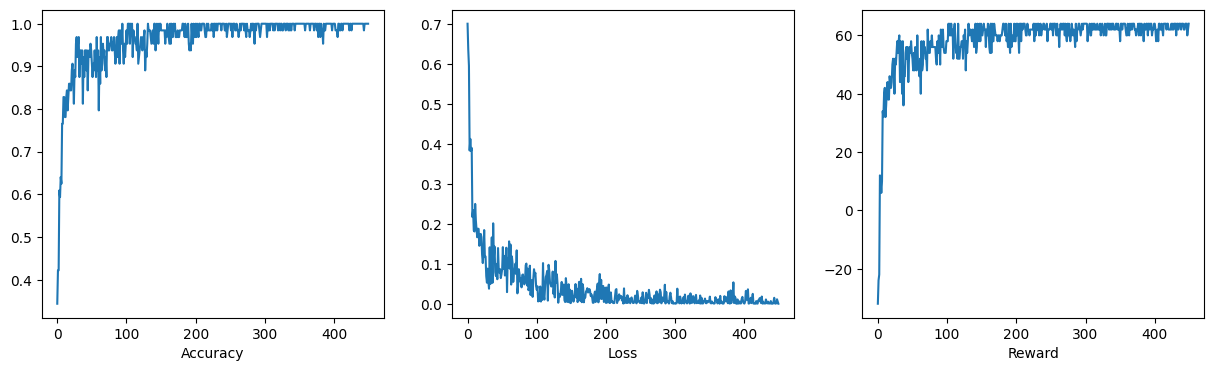

In [17]:
# E = 450 # training episode number
# M = 300 # experience pool capacity
# R = 64 # replay size
# T = 64 # game rounds in one episode
# C = 10 # copy period: training steps to update periodicity of target network
# discount_factor = 0.001 # gamma
# learning_rate = 0.001 # alpha
# # epsilon-greedy:
# # tradeoff between exploration and exploitation
# epsilon_0 = 0.4  # exploration probability at start
# epsilon_min = 0.01  # minimum exploration probability
# epsilon_decay = 0.3  # exponential decay rate for exploration prob
# Modelo con 2 capas de Conv1D

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [26]:
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 0s 5ms/step
Test accuracy:  0.9563465413028879


In [27]:
print(classification_report(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

              precision    recall  f1-score   support

     Healthy     0.9450    0.9286    0.9367       518
    OR fault     1.0000    1.0000    1.0000       484
    IR fault     0.9254    0.9425    0.9339       487

    accuracy                         0.9563      1489
   macro avg     0.9568    0.9570    0.9569      1489
weighted avg     0.9565    0.9563    0.9564      1489



In [50]:
# testing
# Construimos una visualización para la matriz de confusión
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
# Reformateo la matriz para que me quede mejor el gráfico
z_test[[0,2],:] = z_test[[2,0],:]
x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']
z_text = [[str(y) for y in x] for x in z_test]
heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='tealrose')
heatmap.update_layout(title_text='Testing',height=300,width=600,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show() # ver los 23 si son real o provocados

In [67]:
indicesIRHealthy = np.where((np.argmax(testy,axis=1) == 2) & (np.argmax(pred_test,axis=1) == 0))[0]
testX_IRHealthy = testX[indicesIRHealthy]
testX_IRHealthy = testX_IRHealthy.reshape(testX_IRHealthy.shape[0],testX_IRHealthy.shape[1])
testX_IRHealthy.shape

(28, 512)

In [69]:
# load all data
X_ki01, y_ki01 = load_dataset_group('PPDataset/', 'KI01', 'N15_M07_F10') # artificial IR damage
X_ki04, y_ki04 = load_dataset_group('PPDataset/', 'KI04', 'N15_M07_F10') # real IR damage

In [80]:
matches_artificial = []
for i in range(testX_IRHealthy.shape[0]):
    for j in range(X_ki01.shape[0]):
        if(np.array_equal(testX_IRHealthy[i], X_ki01[j])):
            matches_artificial.append(True)
            break
print("Artificial IR damage mistaken for Healthy: ",len(matches_artificial))

matches_real = []
for i in range(testX_IRHealthy.shape[0]):
    for j in range(X_ki04.shape[0]):
        if(np.array_equal(testX_IRHealthy[i], X_ki04[j])):
            matches_real.append(True)
            break
print("Real IR damage mistaken for Healthy: ",len(matches_real))

Artificial IR damage mistaken for Healthy:  22
Real IR damage mistaken for Healthy:  6


Testing con otros settings

In [47]:
# Changing the rotational speed from 1500 rpm to 900 rpm
X_N09_M07_F10, y_N09_M07_F10 = load_dataset_settings(prefix='',setting='N09_M07_F10')
pred_N09_M07_F10 = ddqn_model.predict(X_N09_M07_F10)
acc_N09_M07_F10 = accuracy_score(np.argmax(y_N09_M07_F10,axis=1), np.argmax(pred_N09_M07_F10,axis=1))
print('Test accuracy: ',acc_N09_M07_F10)

(4501, 512, 1) (4501, 3)
141/141 [==============================] - 1s 6ms/step
Test accuracy:  0.6869584536769606


In [48]:
# Changing the load torque from 0.7 Nm to 0.1 Nm
X_N15_M01_F10, y_N15_M01_F10 = load_dataset_settings(prefix='',setting='N15_M01_F10')
pred_N15_M01_F10 = ddqn_model.predict(X_N15_M01_F10)
acc_N15_M01_F10 = accuracy_score(np.argmax(y_N15_M01_F10,axis=1), np.argmax(pred_N15_M01_F10,axis=1))
print('Test accuracy: ',acc_N15_M01_F10)

(4507, 512, 1) (4507, 3)
141/141 [==============================] - 1s 5ms/step
Test accuracy:  0.9531839360994009


In [49]:
# Changing the radial force from 1000 N to 400 N
X_N15_M07_F04, y_N15_M07_F04 = load_dataset_settings(prefix='',setting='N15_M07_F04')
pred_N15_M07_F04 = ddqn_model.predict(X_N15_M07_F04)
acc_N15_M07_F04 = accuracy_score(np.argmax(y_N15_M07_F04,axis=1), np.argmax(pred_N15_M07_F04,axis=1))
print('Test accuracy: ',acc_N15_M07_F04)

(4510, 512, 1) (4510, 3)
141/141 [==============================] - 1s 9ms/step
Test accuracy:  0.9567627494456763


Pruebas (sucio)

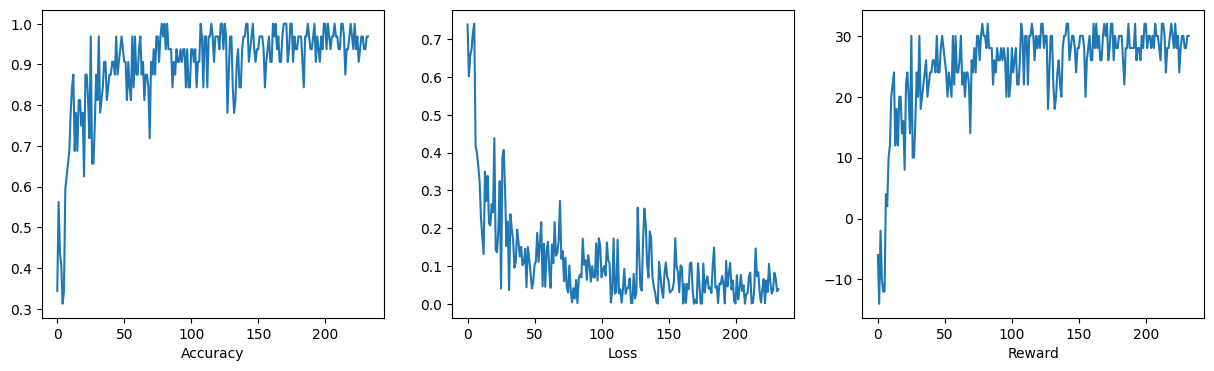

In [24]:
# 233 episodes (porque lo he parado)
# epsilon_0 = 0.4
# epsilon_min = 0.01
# epsilon_decay = 0.01
# epsilon = epsilon_min + (epsilon_0-epsilon_min)*np.exp(-epsilon_decay*reward_count)
# discount_factor = 0.0 !!!
# learning_rate = 0.001

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

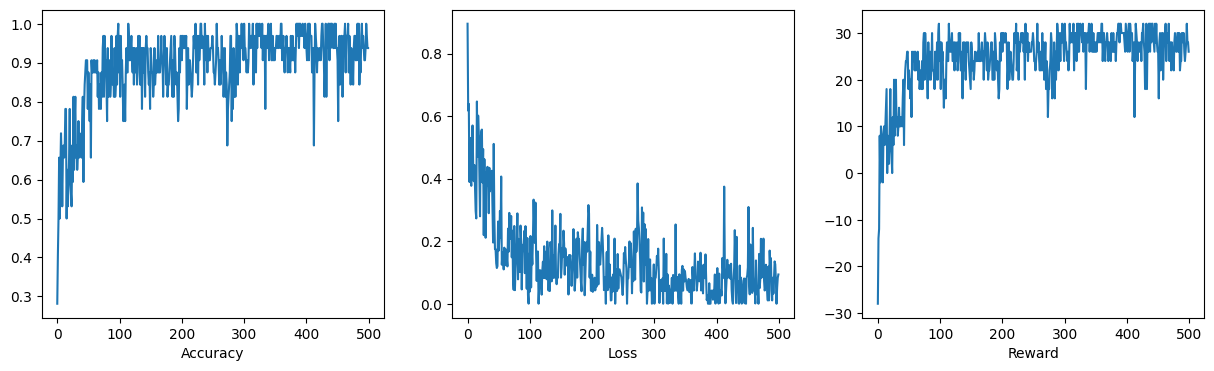

In [19]:
# 500 episodes
# epsilon_0 = 0.4
# epsilon_min = 0.01
# epsilon_decay = 0.01
# epsilon = epsilon_min + (epsilon_0-epsilon_min)*np.exp(-epsilon_decay*reward_count)
# discount_factor = 0.005
# learning_rate = 0.001

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

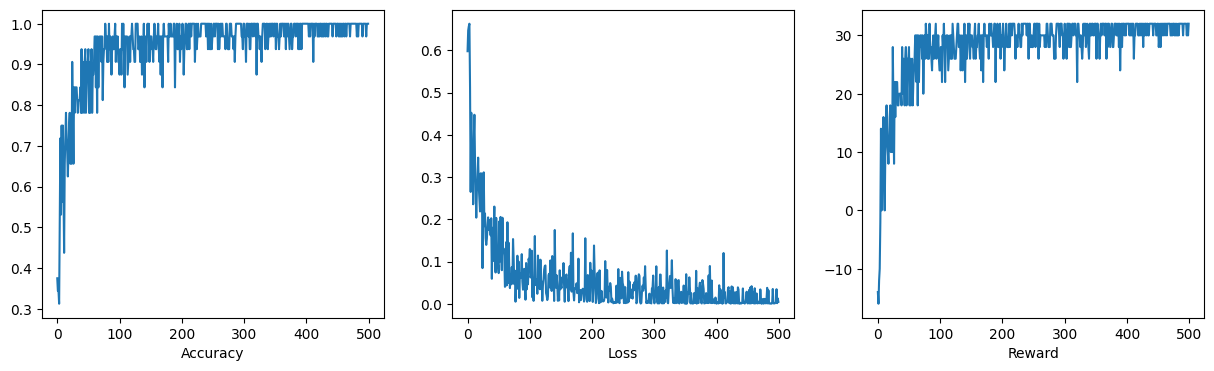

In [90]:
# 500 episodes
# epsilon_0 = 0.4
# epsilon_min = 0.01
# epsilon_decay = 0.3
# epsilon = epsilon_min + (epsilon_0-epsilon_min)*np.exp(-epsilon_decay*episode_count)
# discount_factor = 0.001
# learning_rate = 0.001

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

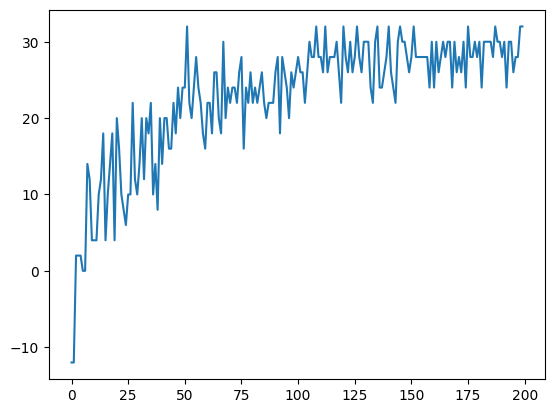

In [422]:
# Con 200 episodes
plt.plot(cum_reward_episode)

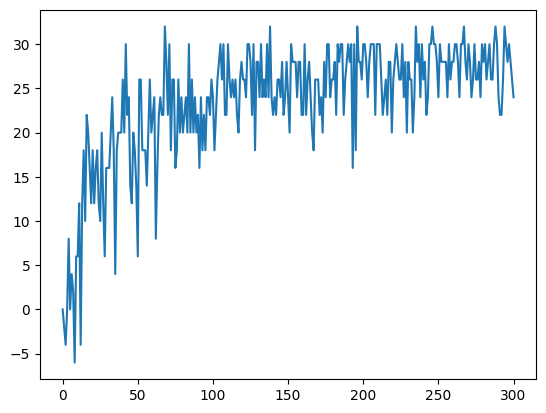

In [428]:
# Con 300 episodes
plt.plot(cum_reward_episode)

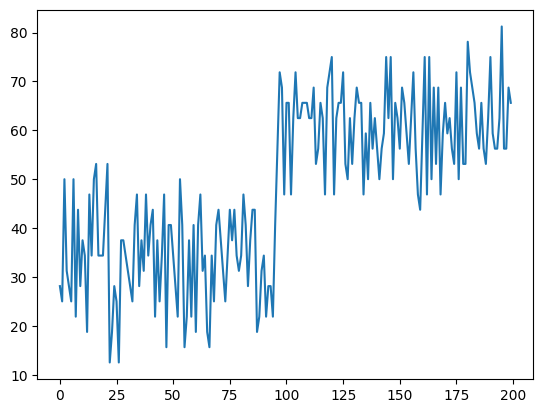

In [349]:
# resultado con los epsilon iniciales (sin decay)
plt.plot((np.asarray(cum_reward_episode)+32)/64*100)

In [423]:
# Testing con 200 episodios
ddqn_model = ddqn_agent.q_policy
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 0s 6ms/step
Test accuracy:  0.9321692411014103


In [429]:
# Testing con 300 episodios
ddqn_model = ddqn_agent.q_policy
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 0s 8ms/step
Test accuracy:  0.8851578240429818


In [80]:
# Testing con 500 episodios
ddqn_model = ddqn_agent.q_policy
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 1s 18ms/step
Test accuracy:  0.9429147078576225


In [20]:
# Testing con 500 episodios y el epsilon con el reward
ddqn_model = ddqn_agent.q_policy
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 0s 8ms/step
Test accuracy:  0.9395567494963063


In [25]:
# Testing con 233 episodios y el epsilon con el reward y gamma 0
ddqn_model = ddqn_agent.q_policy
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

47/47 [==============================] - 0s 10ms/step
Test accuracy:  0.9254533243787777
